In [47]:
from flask import Flask, render_template, request, flash, redirect, url_for
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
# from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math, random
from datetime import date
import datetime as dt
import yfinance as yf
import tweepy
import preprocessor as p
import re
# from sklearn.linear_model import LinearRegression
from textblob import TextBlob
import constants as ct
# from Tweet import Tweet
import nltk
nltk.download('punkt')

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sahup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
start  = '2000-01-01'
end = date.today()
stock = 'RELIANCE.NS'
data = yf.download(stock, start=start, end=end)
df = pd.DataFrame(data=data)
df.to_csv(''+stock+'.csv')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,36.747459,38.944569,36.747459,38.944569,29.773571,28802010
2000-01-04,39.981236,42.062302,38.882679,42.062302,32.157104,61320457
2000-01-05,39.710464,44.545658,39.710464,43.710136,33.416893,173426953
2000-01-06,44.715855,46.526150,44.715855,45.543640,34.818630,101355113
2000-01-07,45.644211,49.187443,45.334759,48.669109,37.208084,128426756


In [50]:
if(df.empty):
            ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
            data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+stock, outputsize='full')
            #Format df
            #Last 2 yrs rows => 502, in ascending order => ::-1
            data=data.head(503).iloc[::-1]
            data=data.reset_index()
            #Keep Required cols only
            df=pd.DataFrame()
            df['Date']=data['date']
            df['Open']=data['1. open']
            df['High']=data['2. high']
            df['Low']=data['3. low']
            df['Close']=data['4. close']
            df['Adj Close']=data['5. adjusted close']
            df['Volume']=data['6. volume']
            df.to_csv(''+stock+'.csv',index=False)

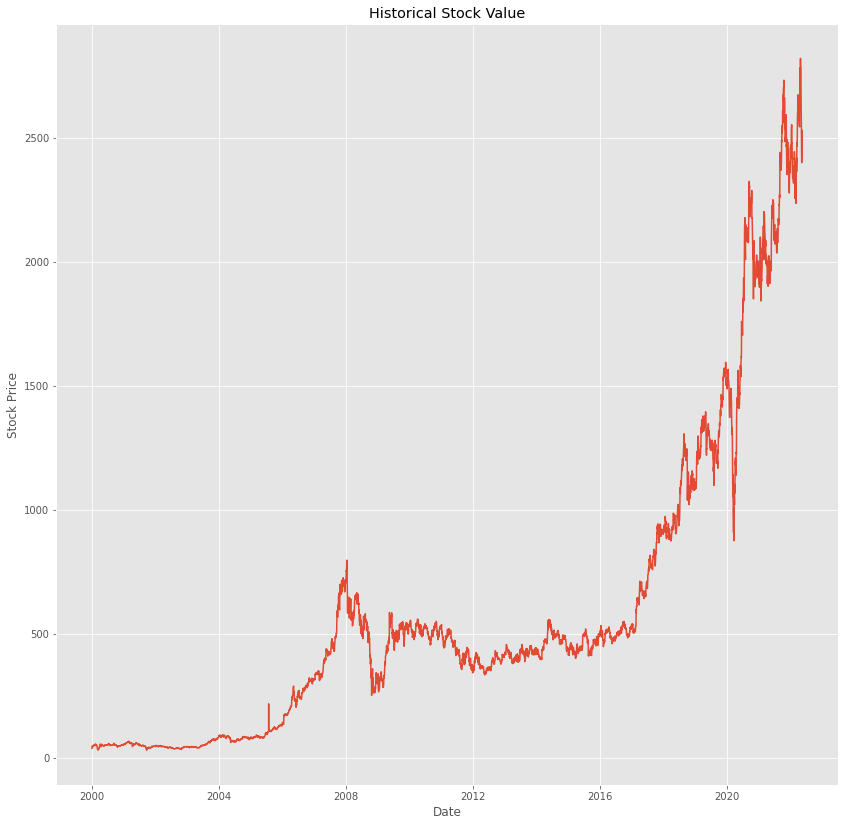

In [29]:
#Visualizing the fetched data
plt.figure(figsize=(14,14))
plt.plot(df['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [30]:
#Split data into training set and test set
dataset_train=df.iloc[0:int(0.8*len(df)),:]
dataset_test=df.iloc[int(0.8*len(df)):,:]

In [31]:
training_set=df.iloc[:,4:5].values

In [32]:
 #Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))#Scaled values btween 0,1
training_set_scaled=sc.fit_transform(training_set)

In [33]:
ma100 = df.Close.rolling(100).mean()
ma100
ma200 = df.Close.rolling(200).mean()
ma200

Date
2000-01-03            NaN
2000-01-04            NaN
2000-01-05            NaN
2000-01-06            NaN
2000-01-07            NaN
                 ...     
2022-05-11    2434.617755
2022-05-12    2436.145754
2022-05-13    2437.675255
2022-05-16    2439.282755
2022-05-17    2441.544254
Name: Close, Length: 5588, dtype: float64

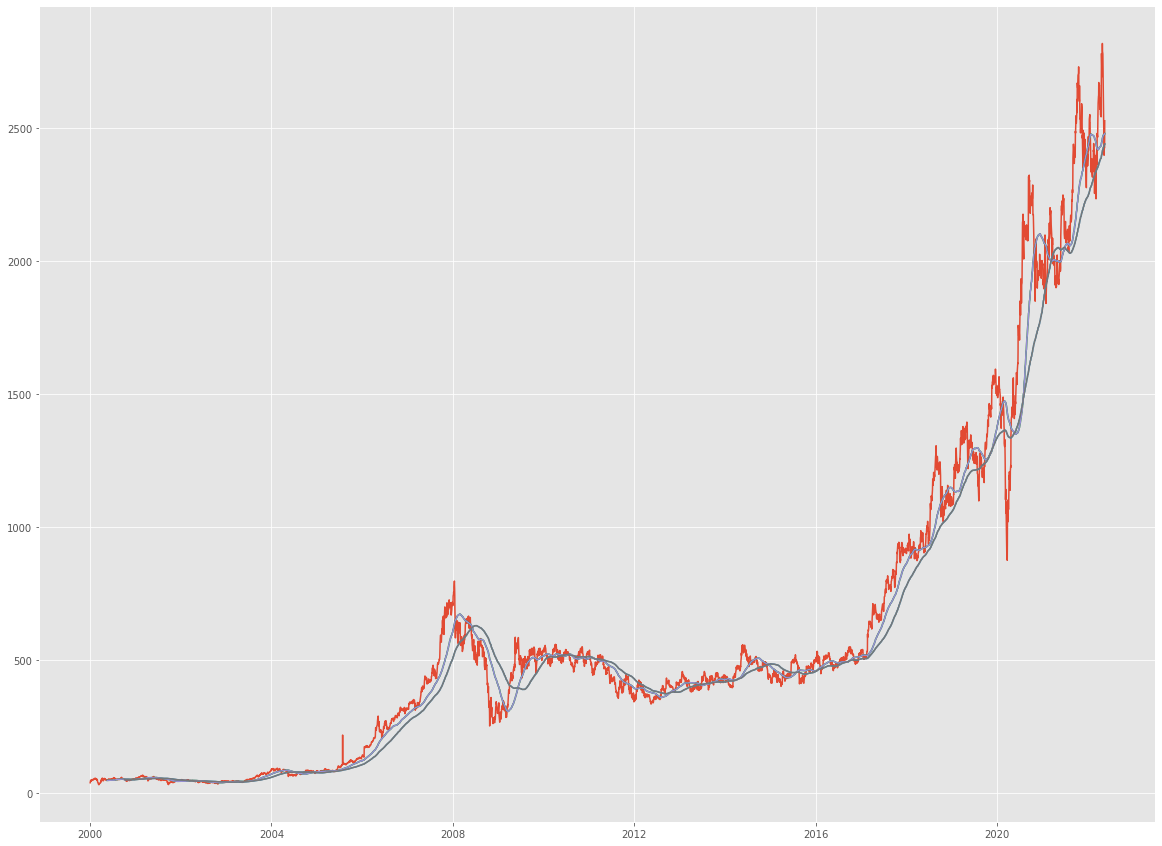

In [34]:
plt.figure(figsize = (20,15))
plt.plot(df.Close)

plt.plot(ma100,'g')
plt.plot(ma200)
plt.plot(ma100,label='100 Day Moving Average')  
plt.plot(ma200,label='200 Day Moving Average')

In [35]:
X_train=[]
y_train=[]
for i in range(100,len(training_set_scaled)):
            X_train.append(training_set_scaled[i-100:i,0])
            y_train.append(training_set_scaled[i,0])
        #Convert list to numpy arrays
X_train=np.array(X_train)
y_train=np.array(y_train)
X_forecast=np.array(X_train[-1,1:])
X_forecast=np.append(X_forecast,y_train[-1])
        #Reshaping: Adding 3rd dimension
X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#.shape 0=row,1=col
X_forecast=np.reshape(X_forecast, (1,X_forecast.shape[0],1))
        #For X_train=np.reshape(no. of rows/samples, timesteps, no. of cols/features)

In [36]:
 #Building RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
        
        #Initialise RNN
regressor=Sequential()
        
        #Add first LSTM layer
regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
        #units=no. of neurons in layer
        #input_shape=(timesteps,no. of cols/features)
        #return_seq=True for sending recc memory. For last layer, retrun_seq=False since end of the line
regressor.add(Dropout(0.1))
        
        #Add 2nd LSTM layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.1))
        
        #Add 3rd LSTM layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.1))
        
        #Add 4th LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.1))
        
        #Add o/p layer
regressor.add(Dense(units=1))

In [37]:
 #Compile
regressor.compile(optimizer='adam',loss='mean_squared_error')
        
        #Training
regressor.fit(X_train,y_train,epochs=50,batch_size=32 )
        #For lstm, batch_size=power of 2

Epoch 1/50
172/172 [==============================] - 27s 121ms/step - loss: 0.0031
Epoch 2/50
172/172 [==============================] - 18s 106ms/step - loss: 8.5399e-04
Epoch 3/50
172/172 [==============================] - 19s 108ms/step - loss: 9.1259e-04
Epoch 4/50
172/172 [==============================] - 17s 100ms/step - loss: 8.7470e-04
Epoch 5/50
172/172 [==============================] - 19s 109ms/step - loss: 6.3570e-04
Epoch 6/50
172/172 [==============================] - 16s 95ms/step - loss: 6.7017e-04
Epoch 7/50
172/172 [==============================] - 19s 108ms/step - loss: 7.6967e-04
Epoch 8/50
172/172 [==============================] - 17s 97ms/step - loss: 5.8007e-04
Epoch 9/50
172/172 [==============================] - 17s 97ms/step - loss: 5.3786e-04
Epoch 10/50
172/172 [==============================] - 18s 104ms/step - loss: 5.7446e-04
Epoch 11/50
172/172 [==============================] - 19s 109ms/step - loss: 5.0217e-04
Epoch 12/50
172/172 [================

In [38]:
#Testing
real_stock_price=dataset_test.iloc[:,4:5].values
regressor.save('complete.h5')
dataset_total=pd.concat((dataset_train['Close'],dataset_test['Close']),axis=0) 
testing_set=dataset_total[ len(dataset_total) -len(dataset_test) -100: ].values
testing_set=testing_set.reshape(-1,1)

In [39]:
 #Feature scaling
testing_set=sc.transform(testing_set)

In [40]:
#Create data structure
X_test=[]
for i in range(100,len(testing_set)):
    X_test.append(testing_set[i-100:i,0])
            #Convert list to numpy arrays
X_test=np.array(X_test)
        
        #Reshaping: Adding 3rd dimension
X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        
        #Testing Prediction
predicted_stock_price=regressor.predict(X_test)

In [41]:
predicted_stock_price.shape

(1118, 1)

In [42]:
real_stock_price

array([[ 906.69378662],
       [ 881.60784912],
       [ 863.230896  ],
       ...,
       [2426.60009766],
       [2427.19995117],
       [2529.14990234]])

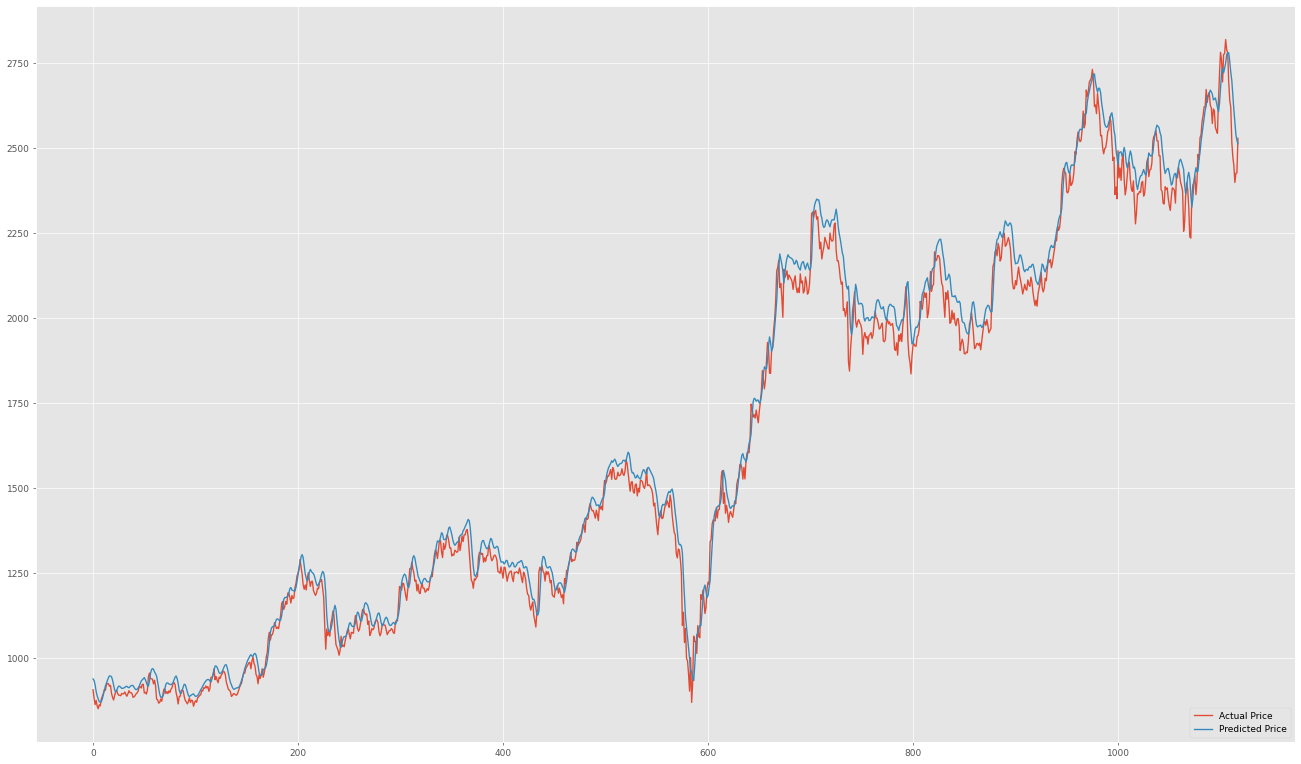

In [43]:
#Getting original prices back from scaled values
predicted_stock_price=sc.inverse_transform(predicted_stock_price)
fig = plt.figure(figsize=(25,15),dpi=65)
plt.plot(real_stock_price,label='Actual Price')  
plt.plot(predicted_stock_price,label='Predicted Price')
          
plt.legend(loc=4)
plt.show()

In [44]:
error_lstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
        
        
        #Forecasting Prediction
forecasted_stock_price=regressor.predict(X_forecast)
        
        #Getting original prices back from scaled values
forecasted_stock_price=sc.inverse_transform(forecasted_stock_price)
     
lstm_pred=forecasted_stock_price[0,0]
print()
print("##############################################################################")
print("Tomorrow's ",stock," Closing Price Prediction by LSTM: ",lstm_pred)
print("LSTM RMSE:",error_lstm)
print("##############################################################################")
forecasted_stock_price.shape 


##############################################################################
Tomorrow's  RELIANCE.NS  Closing Price Prediction by LSTM:  2539.2737
LSTM RMSE: 54.195178035774134
##############################################################################


(1, 1)

In [51]:
import joblib
joblib.dump(regressor,'model.pkl')

INFO:tensorflow:Assets written to: ram://f37ba1e3-a855-4dff-8186-b1521d455653/assets


INFO:tensorflow:Assets written to: ram://f37ba1e3-a855-4dff-8186-b1521d455653/assets


['model.pkl']